In [2]:
from PIL import Image # Part of the standard Python Library
import scipy.ndimage as scimg
from scipy.misc import imresize
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Links
[CDF Gist](https://gist.github.com/CoderSherlock/834e9eb918eeb0dfee5f4550077f57f8)

0. Image: (512, 512)

1. Performing Forward CDF transform....
1. Performed Forward CDF transform
1. im_transform :  (512, 512)

2. Performing Inverse CDF transform....
2. im_recon :  (512, 512)


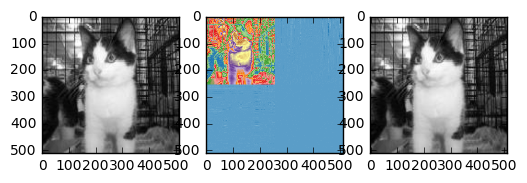

In [9]:
'''
2D CDF 9/7 Wavelet Forward and Inverse Transform (lifting implementation)
This code is provided "as is" and is given for educational purposes.
2008 - Kris Olhovsky - code.inquiries@olhovsky.com
'''

class cdf97():
    def __init__(self):
        self.nlevels = 1
        self.verbose = 0

    def fwt97_2d(self, img, nlevels=1):
        ''' Perform the CDF 9/7 transform on a 2D matrix signal m.
            nlevel is the desired number of times to recursively transform the
            signal. '''
        w = len(img[0])
        h = len(img)
        for i in range(nlevels):
            m = self.fwt97(img, w, h) # cols
            img = self.fwt97(img, w, h) # rows
            w /= 2
            h /= 2

        return img

    def iwt97_2d(self, img, nlevels=1):
        ''' Inverse CDF 9/7 transform on a 2D matrix signal m.
            nlevels must be the same as the nlevels used to perform the fwt.
        '''
        w = len(img[0])
        h = len(img)

        # Find starting size of m:
        for i in range(nlevels-1):
            h /= 2
            w /= 2

        for i in range(nlevels):
            img = self.iwt97(img, w, h) # rows
            img = self.iwt97(img, w, h) # cols
            h *= 2
            w *= 2

        return img

    def fwt97(self, s, width, height):
        ''' Forward Cohen-Daubechies-Feauveau 9 tap / 7 tap wavelet transform
        performed on all columns of the 2D n*n matrix signal s via lifting.
        The returned result is s, the modified input matrix.
        The highpass and lowpass results are stored on the left half and right
        half of s respectively, after the matrix is transposed. '''
        # 9/7 Coefficients:
        a1 = -1.586134342
        a2 = -0.05298011854
        a3 = 0.8829110762
        a4 = 0.4435068522

        # Scale coeff:
        k1 = 0.81289306611596146 # 1/1.230174104914
        k2 = 0.61508705245700002 # 1.230174104914/2
        # Another k used by P. Getreuer is 1.1496043988602418

        for col in range(width): # Do the 1D transform on all cols:
            ''' Core 1D lifting process in this loop. '''
            ''' Lifting is done on the cols. '''

            # Predict 1. y1
            for row in range(1, height-1, 2):
                s[row][col] += a1 * (s[row-1][col] + s[row+1][col])
            s[height-1][col] += 2 * a1 * s[height-2][col] # Symmetric extension

            # Update 1. y0
            for row in range(2, height, 2):
                s[row][col] += a2 * (s[row-1][col] + s[row+1][col])
            s[0][col] +=  2 * a2 * s[1][col] # Symmetric extension

            # Predict 2.
            for row in range(1, height-1, 2):
                s[row][col] += a3 * (s[row-1][col] + s[row+1][col])
            s[height-1][col] += 2 * a3 * s[height-2][col]

            # Update 2.
            for row in range(2, height, 2):
                s[row][col] += a4 * (s[row-1][col] + s[row+1][col])
            s[0][col] += 2 * a4 * s[1][col]

        # de-interleave
        if self.verbose : print ('Height:', height,' Width:', width)
        temp_bank = [[0]*width for i in range(height)]
        for row in range(height):
            for col in range(width):
                # k1 and k2 scale the vals
                # simultaneously transpose the matrix when deinterleaving
                # print ('Col:', col, ' Row:', row,' Row/2', row/2)
                if row % 2 == 0: # even
                    # print ('k1 * s[row][col]:', k1 * s[row][col])
                    temp_bank[col][int(row/2)] = k1 * s[row][col]
                else:            # odd
                    # print ('k2 * s[row][col]:', k2 * s[row][col])
                    temp_bank[col][int(row/2 + height/2)] = k2 * s[row][col]

        # write temp_bank to s:
        for row in range(width):
            for col in range(height):
                s[row][col] = temp_bank[row][col]

        return s

    def iwt97(self, s, width, height):
        ''' Inverse CDF 9/7. '''
        width = int(width)
        height = int(height)

        # 9/7 inverse coefficients:
        a1 = 1.586134342
        a2 = 0.05298011854
        a3 = -0.8829110762
        a4 = -0.4435068522

        # Inverse scale coeffs:
        k1 = 1.230174104914
        k2 = 1.6257861322319229

        # Interleave:
        if self.verbose : print ('Width:', width, ' Height:', height)

        temp_bank = [[0]*width for i in range(height)]
        for col in range(int(width/2)):
            for row in range(height):
                # k1 and k2 scale the vals
                # simultaneously transpose the matrix when interleaving
                temp_bank[col * 2][row] = k1 * s[row][col]
                temp_bank[col * 2 + 1][row] = k2 * s[row][int(col + width/2)]

        # write temp_bank to s:
        for row in range(width):
            for col in range(height):
                s[row][col] = temp_bank[row][col]

        for col in range(width): # Do the 1D transform on all cols:
            ''' Perform the inverse 1D transform. '''

            # Inverse update 2.
            for row in range(2, height, 2):
                s[row][col] += a4 * (s[row-1][col] + s[row+1][col])
            s[0][col] += 2 * a4 * s[1][col]

            # Inverse predict 2.
            for row in range(1, height-1, 2):
                s[row][col] += a3 * (s[row-1][col] + s[row+1][col])
            s[height-1][col] += 2 * a3 * s[height-2][col]

            # Inverse update 1.
            for row in range(2, height, 2):
                s[row][col] += a2 * (s[row-1][col] + s[row+1][col])
            s[0][col] +=  2 * a2 * s[1][col] # Symmetric extension

            # Inverse predict 1.
            for row in range(1, height-1, 2):
                s[row][col] += a1 * (s[row-1][col] + s[row+1][col])
            s[height-1][col] += 2 * a1 * s[height-2][col] # Symmetric extension

        return s

    def seq_to_img(self, m, pix):
        ''' Copy matrix m to pixel buffer pix.
        Assumes m has the same number of rows and cols as pix. '''
        for row in range(len(m)):
            for col in range(len(m[row])):
                pix[col,row] = m[row][col]
            

def gist_technique():
    # Load image.
    im = Image.open("test1_512.png") # Must be a single band image! (grey)

    # Create an image buffer object for fast access.
    pix = im.load()

    # Convert the 2d image to a 1d sequence:
    m = list(im.getdata())

    # Convert the 1d sequence to a 2d matrix.
    # Each sublist represents a row. Access is done via m[row][col].
    m = [m[i:i+im.size[0]] for i in range(0, len(m), im.size[0])]

    # Cast every item in the list to a float:
    for row in range(0, len(m)):
        for col in range(0, len(m[0])):
            m[row][col] = float(m[row][col])

    # Perform a forward CDF 9/7 transform on the image:
    m = fwt97_2d(m, 3)

    seq_to_img(m, pix) # Convert the list of lists matrix to an image.
    im.save("test1_512_fwt.png") # Save the transformed image.

    # Perform an inverse transform:
    m = iwt97_2d(m, 3)

    seq_to_img(m, pix) # Convert the inverse list of lists matrix to an image.
    im.save("test1_512_iwt.png") # Save the inverse transformation.

def me_technique(nlevels = 1, nx = 512, ny = 512):    
    img = scimg.imread("../data/raw_data/cat.1000.jpg", flatten=True)
    im_resize = imresize(img, (nx,ny)) #/255.0
    print ('0. Image:', im_resize.shape)
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(im_resize, cmap = 'gray')
    
    # class definition
    fwt97_obj  = cdf97()
    
    # Perform a forward CDF 9/7 transform on the image:
    print ('\n1. Performing Forward CDF transform....')
    im_resize = im_resize.tolist()
    im_transform = fwt97_obj.fwt97_2d(im_resize, nlevels=nlevels)
    print ('1. Performed Forward CDF transform')
    print ('1. im_transform : ', np.array(im_transform).shape)
    axarr[1].imshow(im_transform, cmap = plt.cm.Paired)
    
    # Perform an inverse CDF 9/7 transform on the image:
    print ('\n2. Performing Inverse CDF transform....')
    im_recon = fwt97_obj.iwt97_2d(im_transform, nlevels=nlevels)
    print ('2. im_recon : ', np.array(im_recon).shape)
    axarr[2].imshow(im_recon, cmap = 'gray')   

if __name__ == "__main__":
    pass
    # gist_technique()
    # me_technique()

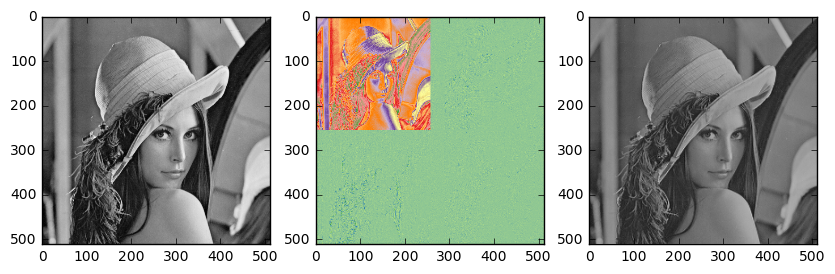

In [188]:
class cdf97_matlab():
    
    def filter9_7(self, verbose = 1):
        p0 = np.array([-5, 0, 49, 0, -245, 0, 1225, 2048, 1225, 0, -245, 0, 49, 0, -5]) / 2048; #half-band filter
        # r = np.roots(p0)
        b0 = np.array([1, 8, 28, 56, 70, 56, 28, 8, 1]);
        q0 = deconvolve(p0,b0)[0]
        
        r = np.vstack( (np.roots(q0).reshape((6,1)), -np.ones((8,1))) )
        
        h0_ip = []
        for each in r[1:5]:
            h0_ip.append(each[0])
        h0_ip.extend([-1, -1, -1, -1])
        h0_ip = np.array(h0_ip)
        if verbose : print ('h0_ip:',h0_ip)
        
        f0_ip = []
        f0_ip.append(r[0][0])
        f0_ip.append(r[5][0])
        f0_ip.extend([-1, -1, -1, -1])
        f0_ip = np.real(np.array(f0_ip))
        if verbose : print ('f0_ip:',f0_ip)
        
        h0 = np.poly(h0_ip)
        f0 = np.poly(f0_ip)
        
        if verbose : 
            print ('\nh0:',h0)
            print ('f0:',f0) 
                      
        h0 = np.real(np.sqrt(2) * h0/sum(h0));
        f0 = np.real(np.sqrt(2) * f0/sum(f0));
        
        if verbose : 
            print ('\nh0:',h0)
            print ('f0:',f0)
        
        f1 = h0 * [(-1) ** i for i in range(0, len(h0))]
        h1 = f0 * [(-1) ** i for i in range(1, len(f0)+1)]
        if verbose : 
            print ('\nh1:',h1)
            print ('f1:',f1)
            
        return h0,h1,f0,f1
    
    def idwt2d(self, x, f0, f1, maxlevel = 1):
        # rx=idwt2d(x,f0,f1,maxlevel);
        # Inverse 2D Discrete Wavelet Transform
        m,n = x.shape
        rx = np.zeros((m,n))
        m = int(m / (2 ** maxlevel))
        n = int(n / (2 ** maxlevel))

        for i in range(maxlevel):            
            xl = self.lphrec(x[0:m, 0:n].T      , x[0:m, n:2*n].T        , f0, f1)
            xh = self.lphrec(x[m:2*m, 0:n].T, x[m:2*m, n:2*n].T, f0, f1)
            x[0:2*m,0:2*n] = self.lphrec(xl.T,xh.T,f0,f1)
            m = int(m*2)
            n = int(n*2)
    
        rx = x
        return rx
    
    def lphrec(self, xl, xh, f0, f1, mode = 1, verbose = 0):
        # x = lphrec(xl,xh,f0,f1,mode)
        # Reconstruction of given scaling and wavelet components into the higher level 
        # scaling coeffs. using a LP PR synthesis bank
        #	Input:
        #		xl  : input scaling coeffs.
        #		      (vector [1,x_len/2] or list of vectors [m,x_len/2])
        #		xh  : input wavelet coeffs.
        #		      (vector [1,x_len/2] or list of vectors [m,x_len/2])
        #		f0  : synthesis filter coeffs. for F0(z) (vector [1,h0_len])
        #		f1  : synthesis filter coeffs. for F1(z) (vector [1,h1_len])
        #		mode: Extension Mode:
        #			0 - zero extension
        #			1 - symmetric extension
        #			2 - circular convolution
        #	Output:
        #		x   : scaling coeffs. at next higher level
        #		      (vector [1,x_len] or list of vectors [m,x_len])

        m, xl_len = xl.shape;
        h0_len = len(f0);
        h1_len = len(f1);
        if h0_len % 2 != h1_len % 2 :
            print('error: filter lengths must be EE or OO!');
        if (m,xl_len) != xh.shape:
            print('error: both channels must have same size!');

        x_len = int(xl_len*2)
        tb = int(h0_len % 2)
        ta = 1-tb
        
        xl2 = np.zeros((m,x_len))
        xh2 = np.zeros((m,x_len))
        
        temp_cols_xl2 = np.arange(2-tb, x_len, 2)
        temp_cols_xh2 = np.arange(1, x_len, 2)
            
        if verbose:
            print ('xl:', xl.shape, ' xl2:', xl2.shape)
            print ('xh:', xh.shape, ' xh2:', xh2.shape)
            print ('2-tb:2:x_len', 2-tb, 2, x_len)
            print ('temp_cols_xl2:', temp_cols_xl2.shape)
            print ('temp_cols_xh2:', temp_cols_xh2.shape)
        
        xl2[:,temp_cols_xl2] = xl;
        xh2[:,temp_cols_xh2] = xh;
        
        ext = int(np.floor(max(h0_len,h1_len)/2))

        if mode == 1:
            if tb == 1:
                xl2 = np.hstack((np.fliplr(xl2[:,2:ext+1+1]), xl2, np.fliplr(xl2[:,x_len-ext:x_len-1+1])));
                xh2 = np.hstack((np.fliplr(xh2[:,2:ext+1+1]), xh2, np.fliplr(xh2[:,x_len-ext:x_len-1+1])));
            else:
                xl2 = np.hstack((np.fliplr(xl2[:,2:ext+1])  , xl2 , np.zeros(m,1), np.fliplr(xl2[:,x_len-ext+1:x_len+1])))
                xh2 = np.hstack((-np.fliplr(xh2[:,2:ext+1]) , xh2 , np.zeros(m,1), -np.fliplr(xh2[:,x_len-ext+1:x_len+1])))
        elif mode == 2:
            xl2 = [xl2[:,x_len-ext+1+ta:x_len], xl2, xl2[:,1:ext+ta]];
            xh2 = [xh2[:,x_len-ext+1+ta:x_len], xh2, xh2[:,1:ext+ta]];

        else:
            xl2 = [np.zeros(m,ext-ta), xl2, np.zeros(m,ext+ta)];
            xh2 = [np.zeros(m,ext-ta), xh2, np.zeros(m,ext+ta)];

        x = np.zeros((m,x_len));
        f0_ord = int(h0_len-1)
        f1_ord = int(h1_len-1)
        s = int((f0_ord-f1_ord) / 2)
        if s >= 0:
            for i in range(0, x_len):
                x[:,i] = np.matmul(xl2[:,i:i+f0_ord+1],f0) + np.matmul(xh2[:,i+s:i+s+f1_ord+1], f1)
        else:
            for i in range(0, x_len):
                x[:,i] = np.matmul(xl2[:,i-s:i-s+f0_ord+1],f0) + np.matmul(xh2[:,i:i+f1_ord+1],f1)
        
        return x

    def dwt2d(self, x, h0, h1, maxlevel = 1):
        # dx=dwt2d(x,h0,h1,level);
        # Forward 2D Discrete Wavelet Transform
        m, n = x.shape
        for i in range(maxlevel):
            [xl,xh]    = self.lphdec(x[0:m,0:n], h0, h1)
            # print ('\nxl : ', xl[0:5, 0:5])
            # print ('\nxh : ', xh[0:5, 0:5])
            [xll,xlh]  = self.lphdec(xl.T, h0, h1);
            [xhl,xhh]  = self.lphdec(xh.T, h0, h1);
            # print ('[xll,xlh] : ', [xll,xlh].shape, ' xll:', xll.shape, ' xlh:', xlh.shape)
            x[0:m,0:n] = np.vstack( ( np.hstack((xll,xhl)), np.hstack((xlh,xhh))) ).T
            # print (x.shape)
            # print (x[0:5, 0:5])
            m = int(m/2)
            n = int(n/2)
        dx = x;
        
        return dx
    
    def lphdec(self, x, h0, h1, mode=1, verbose = 0):
        # [xl,xh] = lphdec(x,h0,h1,mode)
        # Decomposition of given scaling coefficients into their scaling and wavelet 
        # parts using a LP PR analysis bank
        #	Input:
        #		x   : input scaling coeffs. (vector [1,x_len] or 
        #		      matrix [m,x_len], i.e., list of m vectors [1,x_len])
        #		h0  : analysis filter coeffs. for H0(z) (vector [1,h0_len])
        #		h1  : analysis filter coeffs. for H1(z) (vector [1,h1_len])
        #		mode: Extension Mode:
        #			0 - zero extension 
        #			1 - symmetric extension
        #			2 - circular convolution
        #	Output:
        #		xl  : scaling coeffs. at next coarser level (low pass)
        #		      (vector [1,x_len/2] or matrix [m,x_len/2])
        #		xh  : wavelet coeffs. at next coarser level (high pass)
        #		      (vector [1,x_len/2] or matrix [m,x_len/2])

        (m,x_len) = x.shape;
        h0_len = len(h0);
        h1_len = len(h1);
        if h0_len % 2 != h1_len % 2:
            print ('error: filter lengths must be EE or OO!')

        ext = int(np.floor(max(h0_len,h1_len)/2)) # extension size
        tb = int(h0_len % 2)                       # change extension type for EE- or OO-FB
        if mode == 1:
            temp1 = np.fliplr(x[:,1+tb:ext+tb+1])
            temp2 = x
            temp3 = np.fliplr(x[:,x_len-ext+1-tb:x_len-tb+1])
            x = np.hstack((temp1, temp2, temp3))
            if verbose:
                print ('temp1:', temp1.shape, ' temp2:', temp2.shape, ' temp3:', temp3.shape)
                print ('x:', x.shape)

        elif mode == 2:
            x = [x[:,x_len-ext+1:x_len], x, x[:,1:ext]]
        else:
            x = [np.zeros(m,ext), x, np.zeros(m,ext)];

        lenn = int(np.floor((x_len+1)/2))
        xh = np.zeros((m,lenn))
        xl = np.zeros((m,lenn))
        s = (h0_len-h1_len)/2
        
        if s >= 0:
            k1 = int(2 - tb)
            k2 = int(2 + s)
        else:
            k2 = 2
            k1 = int(2 - tb - s)
        
        h0_ord = int(h0_len-1)
        h1_ord = int(h1_len-1)
        
        for i in range(lenn):
            if verbose:
                print ('i:',i)
                print (' x[:,k1:k1+h0_ord+1]:',x[:,k1:k1+h0_ord+1].shape, ' h0:', h0.shape)
                print ('x[:,k1:k1+h0_ord+1] * h0 ', (x[:,k1:k1+h0_ord+1] * h0).shape)
            if i == 0:
                pass
                # print (' x[:,k1:k1+h0_ord+1]:',x[:,k1:k1+h0_ord+1].shape, ' h0:', h0.shape)
                # print (' x[:,k1:k1+h0_ord+1]:',x[:,k1:k1+h0_ord+1][0:5, 0:5], ' h0:', h0)
                # print ('np.matmul(x[:,k1:k1+h0_ord+1], h0)', np.matmul(x[:,k1:k1+h0_ord+1], h0)[:5])
                # print (' x[:,k2:k2+h1_ord+1]:',x[:,k2:k2+h1_ord+1].shape, ' h1:', h1.shape)
                # print (' x[:,k2:k2+h1_ord+1]:',x[:,k2:k2+h1_ord+1][0:5, 0:5], ' h1:', h1)
                # print ('np.matmul(x[:,k2:k2+h1_ord+1], h1)', np.matmul(x[:,k2:k2+h1_ord+1], h1)[:5])
            xl[:,i] = np.matmul(x[:,k1:k1+h0_ord+1], h0)
            xh[:,i] = np.matmul(x[:,k2:k2+h1_ord+1], h1)
            k1 = int(k1 + 2)
            k2 = int(k2 + 2)
        
        return xl, xh

if __name__ == "__main__":
    pass
#     import numpy as np
#     from scipy.ndimage import imread
#     from scipy.signal import deconvolve
#     import matplotlib.pyplot as plt
    
#     %matplotlib inline
#     np.set_printoptions(precision=4)
    
#     f, axarr = plt.subplots(1,3, figsize=(10,10))
#     x = imread('../../data/lena512.bmp', flatten = True)
#     m, n = x.shape
#     axarr[0].imshow(x, cmap = 'gray')
    
#     cdf97_obj = cdf97_matlab()
                      
#     h0,h1,f0,f1 = cdf97_obj.filter9_7(verbose = 0)
#     # L = int(np.floor(np.log2(m)) - 3)
#     L = 1
#     x_coeffs = cdf97_obj.dwt2d(x, h0, h1, L)
#     axarr[1].imshow(x_coeffs, cmap = plt.cm.Paired)
    
#     x_recon = cdf97_obj.idwt2d(x, f0, f1, L)
#     axarr[2].imshow(x_recon, cmap='gray')
